In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [2]:
# Column definitions:
# 1st - Date in Julian day.
# 2nd - Reconstructed total solar irradiance, TSI (units: W m^-2).
# 3rd - The lower uncertainty bound of the TSI series.
# 4th - The upper uncertainty bound of the TSI series.
# 5th - The data the reconstruction is based on (see Sects. 2 and 4.4 in reference [1]).
#        0: Indices of solar magnetic activity
#        1: NASA/NSO 512-channel diode array magnetograph
#        2: NASA/NSO spectromagnetograph
#        3: SoHO/MDI
#        4: SDO/HMI

data = np.genfromtxt('data/TSI/SATIRE-S_TSI_20220923.txt', comments=';')
df = pd.DataFrame(data)

In [3]:
df

,0,1,2,3,4
0,2442283.0,1361.0813,1360.8449,1361.3237,1.0
1,2442284.0,1361.2541,1361.0125,1361.5026,1.0
2,2442285.0,1361.0907,1360.8717,1361.3163,0.0
3,2442286.0,1361.1308,1360.9136,1361.3542,0.0
4,2442287.0,1361.1251,1360.9087,1361.3476,0.0
...,...,...,...,...,...
17559,2459842.0,1361.0877,1361.0028,1361.1777,4.0
17560,2459843.0,1361.1469,1361.0629,1361.2349,4.0
17561,2459844.0,1361.2593,1361.1655,1361.3584,4.0
17562,2459845.0,1361.1732,1361.0684,1361.2857,4.0


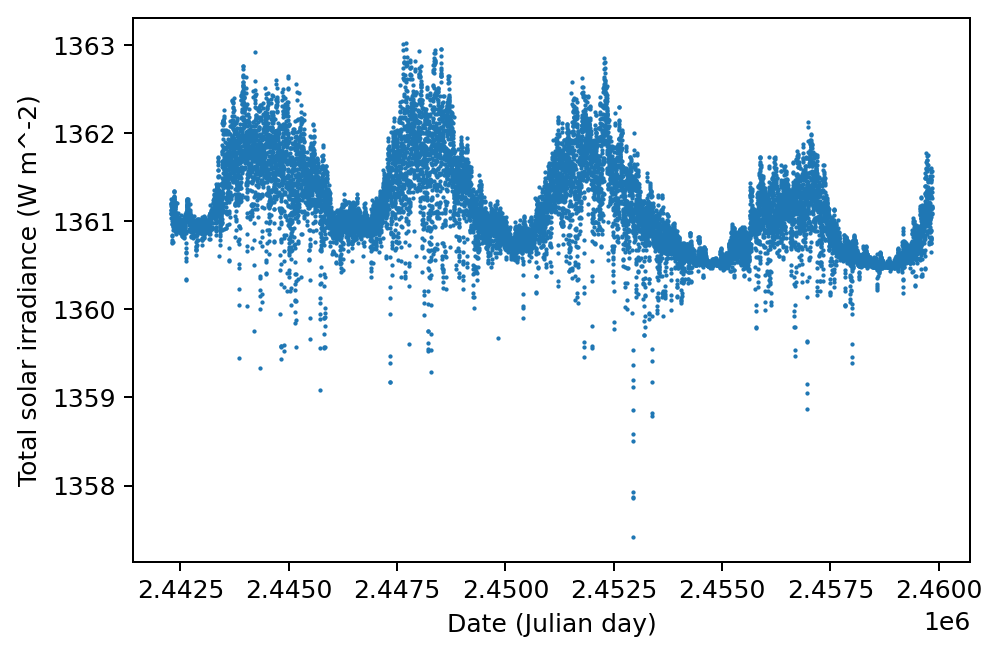

In [4]:
fig, ax = plt.subplots(dpi=180)

ax.scatter(df[0].values, df[1], s=1./2)

ax.set_xlabel('Date (Julian day)')
_ = ax.set_ylabel('Total solar irradiance (W m^-2)')

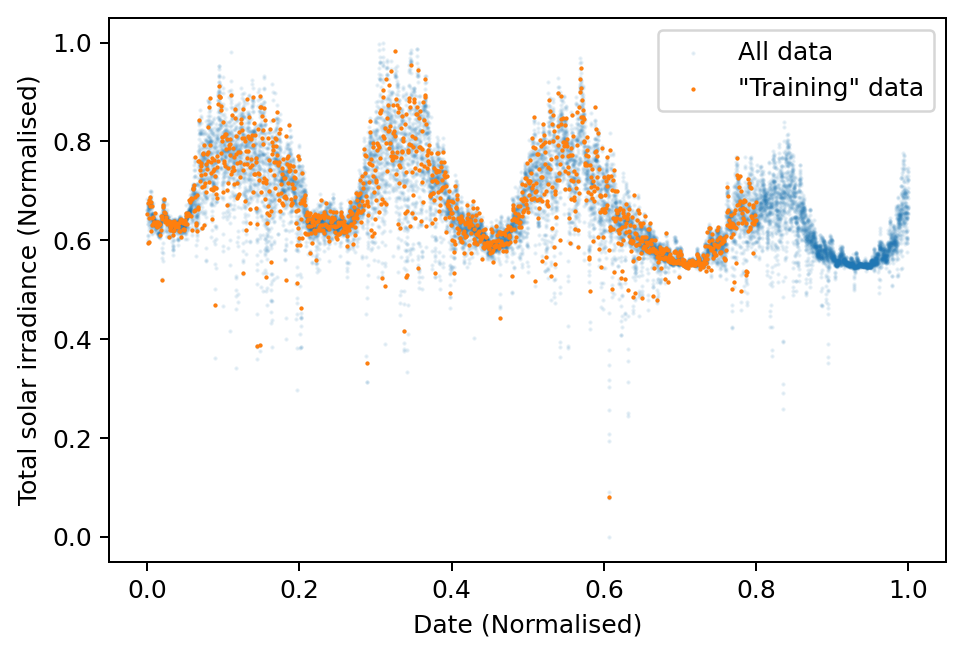

In [5]:
df0_norm = (df[0].values-min(df[0]))/(max(df[0])-min(df[0]))
df1_norm = (df[1].values-min(df[1]))/(max(df[1])-min(df[1]))

x_norm_fit = df0_norm[df0_norm < 0.8][::10]
y_norm_fit = df1_norm[df0_norm < 0.8][::10]

x_norm_test = df0_norm[df0_norm > 0.8]
y_norm_test = df1_norm[df0_norm > 0.8]

fig, ax = plt.subplots(dpi=180)

ax.scatter(df0_norm, df1_norm, s=1./2, alpha=0.1, label='All data')
ax.scatter(x_norm_fit, y_norm_fit, s=1./2, label='"Training" data')

ax.set_xlabel('Date (Normalised)')
ax.set_ylabel('Total solar irradiance (Normalised)')

_ = ax.legend()

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel

seasonal_kernel = (4.0**2
    *RBF(
        length_scale=1.0, 
        length_scale_bounds=[0., 50.]
        )
    *ExpSineSquared(
        length_scale=1.0, 
        periodicity=1.0, 
        length_scale_bounds=[0., 100.], 
        periodicity_bounds=[0., 50]
        )
    )

qbo_kernel = (0.5**2
    *RBF(
        length_scale=1.0,
        length_scale_bounds=[0., 500.]
        )
    *ExpSineSquared(
        length_scale=1.0, 
        periodicity=1.0, 
        length_scale_bounds=[0., 50.], 
        periodicity_bounds=[0., 50]
        )
    )

long_term_trend_kernel = 1.0**2*RBF(length_scale=1.0, length_scale_bounds=[0., 50.])

noise_kernel =  WhiteKernel(noise_level=1.**2, noise_level_bounds=[0., 50.])

kernel = seasonal_kernel + qbo_kernel + long_term_trend_kernel + noise_kernel

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(x_norm_fit[:, np.newaxis], y_norm_fit)
gpr.score(x_norm_fit[:, np.newaxis], y_norm_fit)

/home/efinch/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/efinch/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/efinch/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.562181342985538

In [7]:
pred, std = gpr.predict(df0_norm[:, np.newaxis], return_std=True)

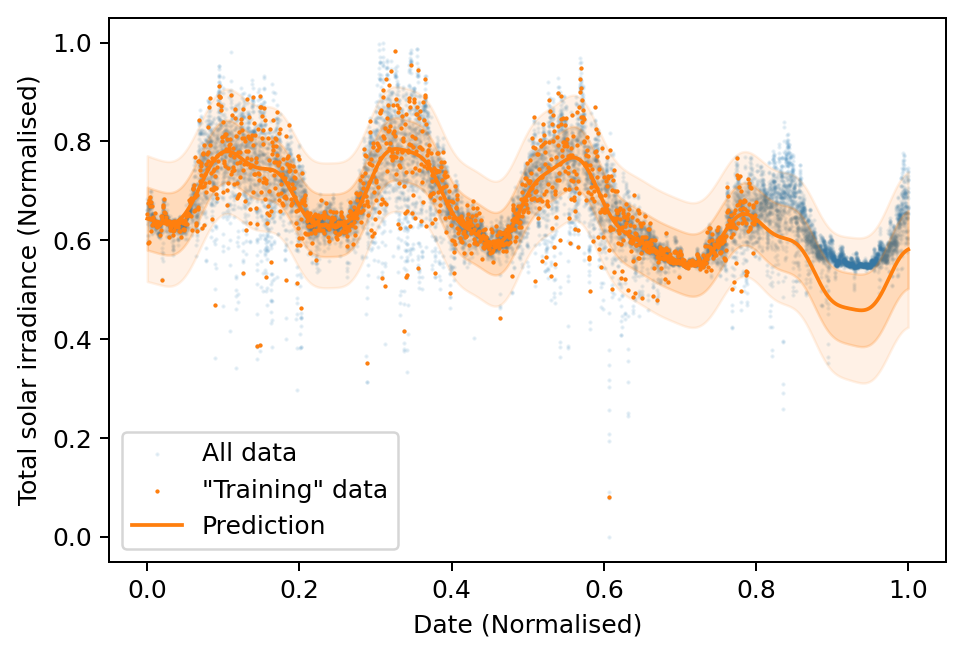

In [8]:
fig, ax = plt.subplots(dpi=180)

ax.scatter(df0_norm, df1_norm, s=1./2, alpha=0.1, label='All data')
ax.scatter(x_norm_fit, y_norm_fit, s=1./2, c='C1', label='"Training" data')

ax.plot(df0_norm, pred, color='C1', label='Prediction')
ax.fill_between(df0_norm, pred+std, (pred-std), color='C1', alpha=0.2)
ax.fill_between(df0_norm, pred+2*std, (pred-2*std), color='C1', alpha=0.1)

ax.set_xlabel('Date (Normalised)')
ax.set_ylabel('Total solar irradiance (Normalised)')

_ = ax.legend()